In [1]:
from pyspark.sql import SQLContext
from pyspark.sql import DataFrameNaFunctions
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import Binarizer
from pyspark.ml.feature import OneHotEncoder, VectorAssembler, StringIndexer, VectorIndexer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.sql.functions import avg
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inlinefrom pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from sklearn.model_selection import train_test_split
from collections import Counter

UsageError: unrecognized arguments: pyspark.ml.evaluation import MulticlassClassificationEvaluator


In [2]:
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
sc = SparkContext('local')
spark = SparkSession(sc)

In [3]:
df = spark.read.format('com.databricks.spark.csv').options(header=True, inferschema=True).load('stroke.csv')

In [4]:
featureColumns = ['gender','age','diabetes','hypertension',
 'heart disease','smoking history','BMI']

In [52]:
featureColumns

['gender',
 'age',
 'diabetes',
 'hypertension',
 'heart disease',
 'smoking history',
 'BMI']

In [5]:
df = df.filter(df.age >2)
df.count()

96713

([<matplotlib.axis.XTick at 0x7fbe3bf2c100>,
 [Text(0.175, 0, '1'), Text(1.175, 0, '0')])

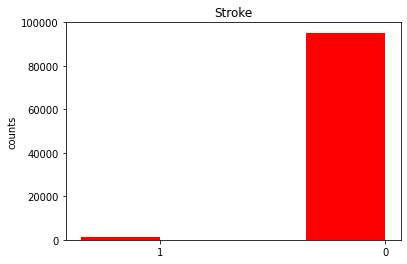

In [6]:
responses = df.groupBy('stroke').count().collect()
categories = [i[0] for i in responses]
counts = [i[1] for i in responses]
 
ind = np.array(range(len(categories)))
width = 0.35
plt.bar(ind, counts, width=width, color='r')
 
plt.ylabel('counts')
plt.title('Stroke')
plt.xticks(ind + width/2., categories)

In [7]:
imputeDF = df
imputeDF_Pandas = imputeDF.toPandas()

In [8]:
df_2_9 = imputeDF_Pandas[(imputeDF_Pandas['age'] >=2 ) & (imputeDF_Pandas['age'] <= 9)]
values = {'smoking history': 0, 'BMI':17.125}
df_2_9 = df_2_9.fillna(value = values)
df_10_13 = imputeDF_Pandas[(imputeDF_Pandas['age'] >=10 ) & (imputeDF_Pandas['age'] <= 13)]
values = {'smoking history': 0, 'BMI':19.5}
df_10_13 = df_10_13.fillna(value = values)
df_14_17 = imputeDF_Pandas[(imputeDF_Pandas['age'] >=14 ) & (imputeDF_Pandas['age'] <= 17)]
values = {'smoking history': 0, 'BMI':23.05}
df_14_17 = df_14_17.fillna(value = values)
df_18_24 = imputeDF_Pandas[(imputeDF_Pandas['age'] >=18 ) & (imputeDF_Pandas['age'] <= 24)]
values = {'smoking history': 0, 'BMI':27.1}
df_18_24 = df_18_24.fillna(value = values)
df_25_29 = imputeDF_Pandas[(imputeDF_Pandas['age'] >=25 ) & (imputeDF_Pandas['age'] <= 29)]
values = {'smoking history': 0, 'BMI':27.9}
df_25_29 = df_25_29.fillna(value = values)
df_30_34 = imputeDF_Pandas[(imputeDF_Pandas['age'] >=30 ) & (imputeDF_Pandas['age'] <= 34)]
values = {'smoking history': 0.25, 'BMI':29.6}
df_30_34 = df_30_34.fillna(value = values)
df_35_44 = imputeDF_Pandas[(imputeDF_Pandas['age'] >=35 ) & (imputeDF_Pandas['age'] <= 44)]
values = {'smoking history': 0.25, 'BMI':30.15}
df_35_44 = df_35_44.fillna(value = values)
df_45_49 = imputeDF_Pandas[(imputeDF_Pandas['age'] >=45 ) & (imputeDF_Pandas['age'] <= 49)]
values = {'smoking history': 0, 'BMI':29.7}
df_45_49 = df_45_49.fillna(value = values)
df_50_59 = imputeDF_Pandas[(imputeDF_Pandas['age'] >=50 ) & (imputeDF_Pandas['age'] <= 59)]
values = {'smoking history': 0, 'BMI':29.95}
df_50_59 = df_50_59.fillna(value = values)
df_60_74 = imputeDF_Pandas[(imputeDF_Pandas['age'] >=60 ) & (imputeDF_Pandas['age'] <= 74)]
values = {'smoking history': 0, 'BMI':30.1}
df_60_74 = df_60_74.fillna(value = values)
df_75_plus = imputeDF_Pandas[(imputeDF_Pandas['age'] >75 )]
values = {'smoking history': 0, 'BMI':28.1}
df_75_plus = df_75_plus.fillna(value = values)

In [9]:
all_frames = [df_2_9, df_10_13, df_14_17, df_18_24, df_25_29, df_30_34, df_35_44, df_45_49, df_50_59, df_60_74, df_75_plus]
df_combined = pd.concat(all_frames)
df_combined_converted = spark.createDataFrame(df_combined)
imputeDF = df_combined_converted

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
X = imputeDF.toPandas().filter(items=['gender', 'age', 'diabetes','hypertension','heart disease','smoking history','BMI'])
Y = imputeDF.toPandas().filter(items=['stroke'])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=0)

In [12]:
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from collections import Counter

In [13]:
sm = SMOTE(random_state=12, sampling_strategy = 'auto')
x_train_res, y_train_res = sm.fit_sample(X_train, Y_train)
print('Resampled dataset shape {}'.format(Counter(y_train_res)))

Resampled dataset shape Counter({'stroke': 1})


In [14]:
dataframe_1 = pd.DataFrame(x_train_res,columns=['gender', 'age', 'diabetes', 'hypertension', 'heart disease', 'smoking history', 'BMI'])
dataframe_2 = pd.DataFrame(y_train_res, columns = ['stroke'])# frames = [dataframe_1, dataframe_2]
result = dataframe_1.combine_first(dataframe_2)

In [16]:
result.astype({'stroke': 'float'}).dtypes

BMI                float64
age                float64
diabetes             int64
gender               int64
heart disease      float64
hypertension         int64
smoking history    float64
stroke             float64
dtype: object

In [25]:
imputeDF_1 = spark.createDataFrame(result)
imputeDF_1 = imputeDF_1.withColumn("stroke",imputeDF_1["stroke"].cast('double'))

In [42]:
binarizer = Binarizer(threshold=0.0, inputCol='stroke', outputCol='label')
binarizedDF = binarizer.transform(imputeDF_1)
binarizedDF = binarizedDF.drop('stroke')

In [56]:
assembler = VectorAssembler(inputCols = featureColumns, outputCol = "features")
assembled = assembler.setHandleInvalid("keep").transform(binarizedDF)
print(assembled)

DataFrame[BMI: double, age: double, diabetes: bigint, gender: bigint, heart disease: double, hypertension: bigint, smoking history: double, label: double, features: vector]


In [57]:
(trainingData, testData) = assembled.randomSplit([0.7, 0.3], seed=0)
print("Distribution of Ones and Zeros in trainingData is: ", trainingData.groupBy("label").count().take(3))

Distribution of Ones and Zeros in trainingData is:  [Row(label=0.0, count=59507), Row(label=1.0, count=59379)]


In [58]:
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features", maxDepth=25, minInstancesPerNode=30, impurity="gini")
pipeline = Pipeline(stages=[dt])
model = pipeline.fit(trainingData)

In [59]:
predictions = model.transform(testData)

In [60]:
predictions

DataFrame[BMI: double, age: double, diabetes: bigint, gender: bigint, heart disease: double, hypertension: bigint, smoking history: double, label: double, features: vector, rawPrediction: vector, probability: vector, prediction: double]

In [62]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics as metric
results = predictions.select(['probability', 'label'])
 
## prepare score-label set
results_collect = results.collect()
results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]
scoreAndLabels = sc.parallelize(results_list)
 
metrics = metric(scoreAndLabels)
print("Test Data Area under ROC score is : ", metrics.areaUnderROC)



Test Data Area under ROC score is :  0.8554662369147434


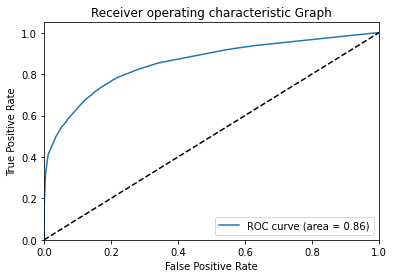

In [63]:
from sklearn.metrics import roc_curve, auc
 
fpr = dict()
tpr = dict()
roc_auc = dict()
 
y_test = [i[1] for i in results_list]
y_score = [i[0] for i in results_list]
 
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
 
%matplotlib inline
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic Graph')
plt.legend(loc="lower right")
plt.show()